In [ ]:
* The following codes comes from the original DBPN project. 
* We are not going to directly train the model. Instead, based on the pretrained model,
* We transfer the knowledge to our SRDectection Model.

In [2]:
from __future__ import print_function
import argparse

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from dbpn import Net as DBPN
from dbpn_v1 import Net as DBPNLL
from data import get_eval_set
from functools import reduce

from scipy.misc import imsave
import scipy.io as sio
import time
import cv2
import sys; sys.argv=['']; del sys

In [3]:
# Training settings
parser = argparse.ArgumentParser(description='PyTorch Super Res Example')
parser.add_argument('--upscale_factor', type=int, default=8, help="super resolution upscale factor")
parser.add_argument('--testBatchSize', type=int, default=1, help='testing batch size')
parser.add_argument('--gpu_mode', type=bool, default=True)
parser.add_argument('--self_ensemble', type=bool, default=False)
parser.add_argument('--chop_forward', type=bool, default=False)
parser.add_argument('--threads', type=int, default=1, help='number of threads for data loader to use')
parser.add_argument('--seed', type=int, default=123, help='random seed to use. Default=123')
parser.add_argument('--gpus', default=1, type=float, help='number of gpu')

parser.add_argument('--input_dir', type=str, default='../dataset')
parser.add_argument('--output', default='../dataset/results', help='Location to save checkpoint models')
parser.add_argument('--test_dataset', type=str, default='VOC12-LR-X8-restore')
parser.add_argument('--model_type', type=str, default='DBPN')
parser.add_argument('--model', default='models/DBPN_x8.pth', help='sr pretrained base model')

opt = parser.parse_args()

gpus_list=range(opt.gpus)
print(opt)

cuda = opt.gpu_mode
if cuda and not torch.cuda.is_available():
    raise Exception("No GPU found, please run without --cuda")

torch.manual_seed(opt.seed)
if cuda:
    torch.cuda.manual_seed(opt.seed)


Namespace(chop_forward=False, gpu_mode=True, gpus=1, input_dir='../dataset', model='models/DBPN_x8.pth', model_type='DBPN', output='../dataset/results', seed=123, self_ensemble=False, testBatchSize=1, test_dataset='VOC12-LR-X8-restore', threads=1, upscale_factor=8)


In [4]:
print('===> Loading datasets')
test_set = get_eval_set(os.path.join(opt.input_dir,opt.test_dataset))
testing_data_loader = DataLoader(dataset=test_set, num_workers=opt.threads, batch_size=opt.testBatchSize, shuffle=False)

print('===> Building model')
if opt.model_type == 'DBPNLL':
    model = DBPNLL(num_channels=3, base_filter=64,  feat = 256, num_stages=10, scale_factor=opt.upscale_factor) ##For NTIRE2018
else:
    model = DBPN(num_channels=3, base_filter=64,  feat = 256, num_stages=7, scale_factor=opt.upscale_factor) ###D-DBPN

if cuda:
    model = torch.nn.DataParallel(model, device_ids=gpus_list)

if os.path.exists(opt.model):
    #model= torch.load(opt.model, map_location=lambda storage, loc: storage)
    model.load_state_dict(torch.load(opt.model, map_location=lambda storage, loc: storage))
    print('Pre-trained SR model is loaded.')

if cuda:
    model = model.cuda(gpus_list[0])

def eval():
    model.eval()
    for i,batch in enumerate(testing_data_loader):
        input, name = batch[0], batch[1]
        if cuda:
            input = input.cuda(gpus_list[0])

        t0 = time.time()
        if opt.chop_forward:
            prediction = chop_forward(input, model, opt.upscale_factor)
        else:
            if opt.self_ensemble:
                prediction = x8_forward(input, model)
            else:
                prediction = model(input)
        t1 = time.time()
        print("===> Processing: %s || Timer: %.4f sec." % (name[0], (t1 - t0)))
        save_img(prediction.cpu().data, name[0])
        if i > 8:
            break

def save_img(img, img_name):
    save_img = img.squeeze().clamp(0, 1).numpy().transpose(1,2,0)

    # save img
    save_dir=os.path.join(opt.output,opt.test_dataset)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        
    save_fn = save_dir +'/'+ img_name
    cv2.imwrite(save_fn, cv2.cvtColor(save_img*255, cv2.COLOR_BGR2RGB),  [cv2.IMWRITE_PNG_COMPRESSION, 0])
    cv2
#####x8_forward and chop_forward taken from https://github.com/thstkdgus35/EDSR-PyTorch
#####EDSR and MDSR Team from SNU
def x8_forward(img, model, precision='single'):
    def _transform(v, op):
        if precision != 'single': v = v.float()

        v2np = v.data.cpu().numpy()
        if op == 'vflip':
            tfnp = v2np[:, :, :, ::-1].copy()
        elif op == 'hflip':
            tfnp = v2np[:, :, ::-1, :].copy()
        elif op == 'transpose':
            tfnp = v2np.transpose((0, 1, 3, 2)).copy()
        
        #ret = torch.Tensor(tfnp).cuda()
        ret = torch.Tensor(tfnp)

        if precision == 'half':
            ret = ret.half()
        elif precision == 'double':
            ret = ret.double()

        return Variable(ret, volatile=v.volatile)

    inputlist = [img]
    for tf in 'vflip', 'hflip', 'transpose':
        inputlist.extend([_transform(t, tf) for t in inputlist])

    outputlist = [model(aug) for aug in inputlist]
    for i in range(len(outputlist)):
        if i > 3:
            outputlist[i] = _transform(outputlist[i], 'transpose')
        if i % 4 > 1:
            outputlist[i] = _transform(outputlist[i], 'hflip')
        if (i % 4) % 2 == 1:
            outputlist[i] = _transform(outputlist[i], 'vflip')
    
    output = reduce((lambda x, y: x + y), outputlist) / len(outputlist)

    return output
    
def chop_forward(x, model, scale, shave=16, min_size=10000, nGPUs=opt.gpus):
    b, c, h, w = x.size()
    h_half, w_half = h // 2, w // 2
    h_size, w_size = h_half + shave, w_half + shave
    inputlist = [
        x[:, :, 0:h_size, 0:w_size],
        x[:, :, 0:h_size, (w - w_size):w],
        x[:, :, (h - h_size):h, 0:w_size],
        x[:, :, (h - h_size):h, (w - w_size):w]]

    if w_size * h_size < min_size:
        outputlist = []
        for i in range(0, 4, nGPUs):
            input_batch = torch.cat(inputlist[i:(i + nGPUs)], dim=0)
            if opt.self_ensemble:
                output_batch = x8_forward(input_batch, model)
            else:
                output_batch = model(input_batch)
            outputlist.extend(output_batch.chunk(nGPUs, dim=0))
    else:
        outputlist = [
            chop_forward(patch, model, scale, shave, min_size, nGPUs) \
            for patch in inputlist]

    h, w = scale * h, scale * w
    h_half, w_half = scale * h_half, scale * w_half
    h_size, w_size = scale * h_size, scale * w_size
    shave *= scale

    output = Variable(x.data.new(b, c, h, w), volatile=True)
    output[:, :, 0:h_half, 0:w_half] \
        = outputlist[0][:, :, 0:h_half, 0:w_half]
    output[:, :, 0:h_half, w_half:w] \
        = outputlist[1][:, :, 0:h_half, (w_size - w + w_half):w_size]
    output[:, :, h_half:h, 0:w_half] \
        = outputlist[2][:, :, (h_size - h + h_half):h_size, 0:w_half]
    output[:, :, h_half:h, w_half:w] \
        = outputlist[3][:, :, (h_size - h + h_half):h_size, (w_size - w + w_half):w_size]

    return output

##Eval Start!!!!
eval()

===> Loading datasets
===> Building model


/home/shared/detection/dbpn/dbpn.py:47: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  torch.nn.init.kaiming_normal(m.weight)
/home/shared/detection/dbpn/dbpn.py:51: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  torch.nn.init.kaiming_normal(m.weight)


Pre-trained SR model is loaded.
===> Processing: 2012_002263.jpg || Timer: 0.0418 sec.
===> Processing: 2009_000746.jpg || Timer: 0.0388 sec.
===> Processing: 2010_002312.jpg || Timer: 0.0083 sec.
===> Processing: 2008_005616.jpg || Timer: 0.0081 sec.
===> Processing: 2008_003323.jpg || Timer: 0.0100 sec.
===> Processing: 2009_001110.jpg || Timer: 0.0081 sec.
===> Processing: 2011_006531.jpg || Timer: 0.0206 sec.
===> Processing: 2011_000207.jpg || Timer: 0.0082 sec.
===> Processing: 2011_006864.jpg || Timer: 0.0081 sec.
===> Processing: 2011_005395.jpg || Timer: 0.0080 sec.


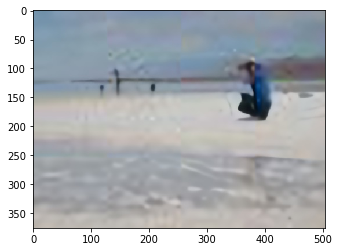

In [9]:
from PIL import Image
from os import listdir
from os.path import isfile,join
import matplotlib.pyplot as plt

image_dir = "../dataset/results/VOC12-LR-X8-restore"
img = Image.open(join(image_dir,"2012_002263.jpg"))
plt.imshow(img)
plt.show()
img.close()